In [11]:
import sys
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np
import os

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

/share/PI/rondror/software/miniconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [12]:
data_set_dir = '/scratch/PI/rondror/docking_data/CDK2/'   
   
rmsd_file = 'rmsd.csv'
ligands_dir = data_set_dir + 'ligands/'
grids_dir = data_set_dir + 'grids/'
glide_dir = data_set_dir + 'glide/'
crystal_fp_file = data_set_dir + 'crystal_ifp_old/ifp.fp'
docking_fp_dir = data_set_dir + 'glide_ifp_old/'

crystal_fp_file2 = data_set_dir + 'crystal_jetynan/ifp.fp'
docking_fp_dir2 = data_set_dir + 'glide_fp_jetynan/'

In [13]:
## useful class specifications:
# Ligand -- attributes: crystal (currently not used/none), poses (dict of pose_num:pose).
# Pose -- attributes: rmsd (float), fp (Fingerprint, num (integer), gscore (float)
# FuzzyFingerPrint -- attributes: pdb, feats (dict of residue name:interaction list).

# crystals: maps structures to Poses, 
#           e.g., crystals['4LDO'] = Pose(rmsd=0, fingerprint, num=0, gscore=0)
# glides:   maps ligand_struct, grid_struct to Ligands, 
#           e.g., glides['4LDO']['4LDO'] = Ligand(...)

## STEP 1:
## load in the crystal structures, docking results, and fingerprints
(crystals, glides) = load_data(
    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file, docking_fp_dir)

(crystals2, glides2) = load_data(
    data_set_dir, rmsd_file, ligands_dir, grids_dir, glide_dir, crystal_fp_file2, docking_fp_dir2)

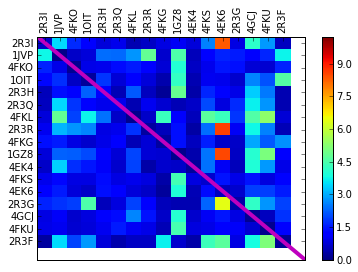

In [14]:
## STEP 2:
## visualize docking results

# in the heatmaps, each row is a structure and each column is a ligand

get_ipython().magic(u'matplotlib inline')

max_num_poses = 50

# this shows the rmsds of glide's top ranked poses (pose 0)
top_rmsd_matrix = top_pose(glides)
#heatmap(top_rmsd_matrix, glides)

# this shows the losest rmsd in the first 'max_num_poses' poses
best_rmsd_matrix = best_pose(glides, max_num_poses)
heatmap(best_rmsd_matrix, glides)

In [15]:
## STEP 3:
## pick 1 receptor structure to use for all ligands
## filter ligands that are poorly docked

rmsd_filter = lambda x: x < 2
best_structure, filtered_ligands, ave_rmsd = get_structure_and_ligands(best_rmsd_matrix, rmsd_filter, glides.keys())

print 'The best structure is ' + best_structure
print str(len(filtered_ligands)) + ' of ' + str(len(glides.keys())) + ' ligands were docked well:'
print filtered_ligands
print 'with an average best rmsd of ' + str(ave_rmsd)[:5]

The best structure is 4FKU
16 of 17 ligands were docked well:
['2R3I', '1JVP', '4FKO', '1OIT', '2R3H', '2R3Q', '4FKL', '2R3R', '4FKG', '4EK4', '4FKS', '4EK6', '2R3G', '4GCJ', '4FKU', '2R3F']
with an average best rmsd of 0.923


In [16]:
## STEP 4:
## score all pairs of ligands

# optional arguments: overlap (function) and weights (dictionary of interaction_index to weight)
scores = Scores(glides, crystals, filtered_ligands, best_structure, max_num_poses)

In [17]:
scores2 = Scores(glides2, crystals2, filtered_ligands, best_structure, max_num_poses)

Average rmsd change = -0.7116875
If that number is negative, scores2 is better than scores1!


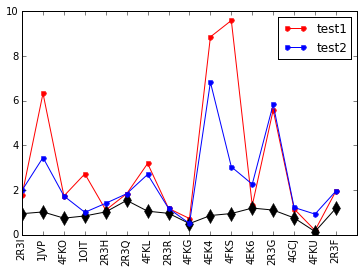

In [18]:
## STEP 5:
## plot results

plot_final_rmsds(scores,'test1',scores2,'test2')
#plot_final_scores(scores)

Average rmsd change = 0.207991666667
If that number is negative, scores2 is better than scores1!


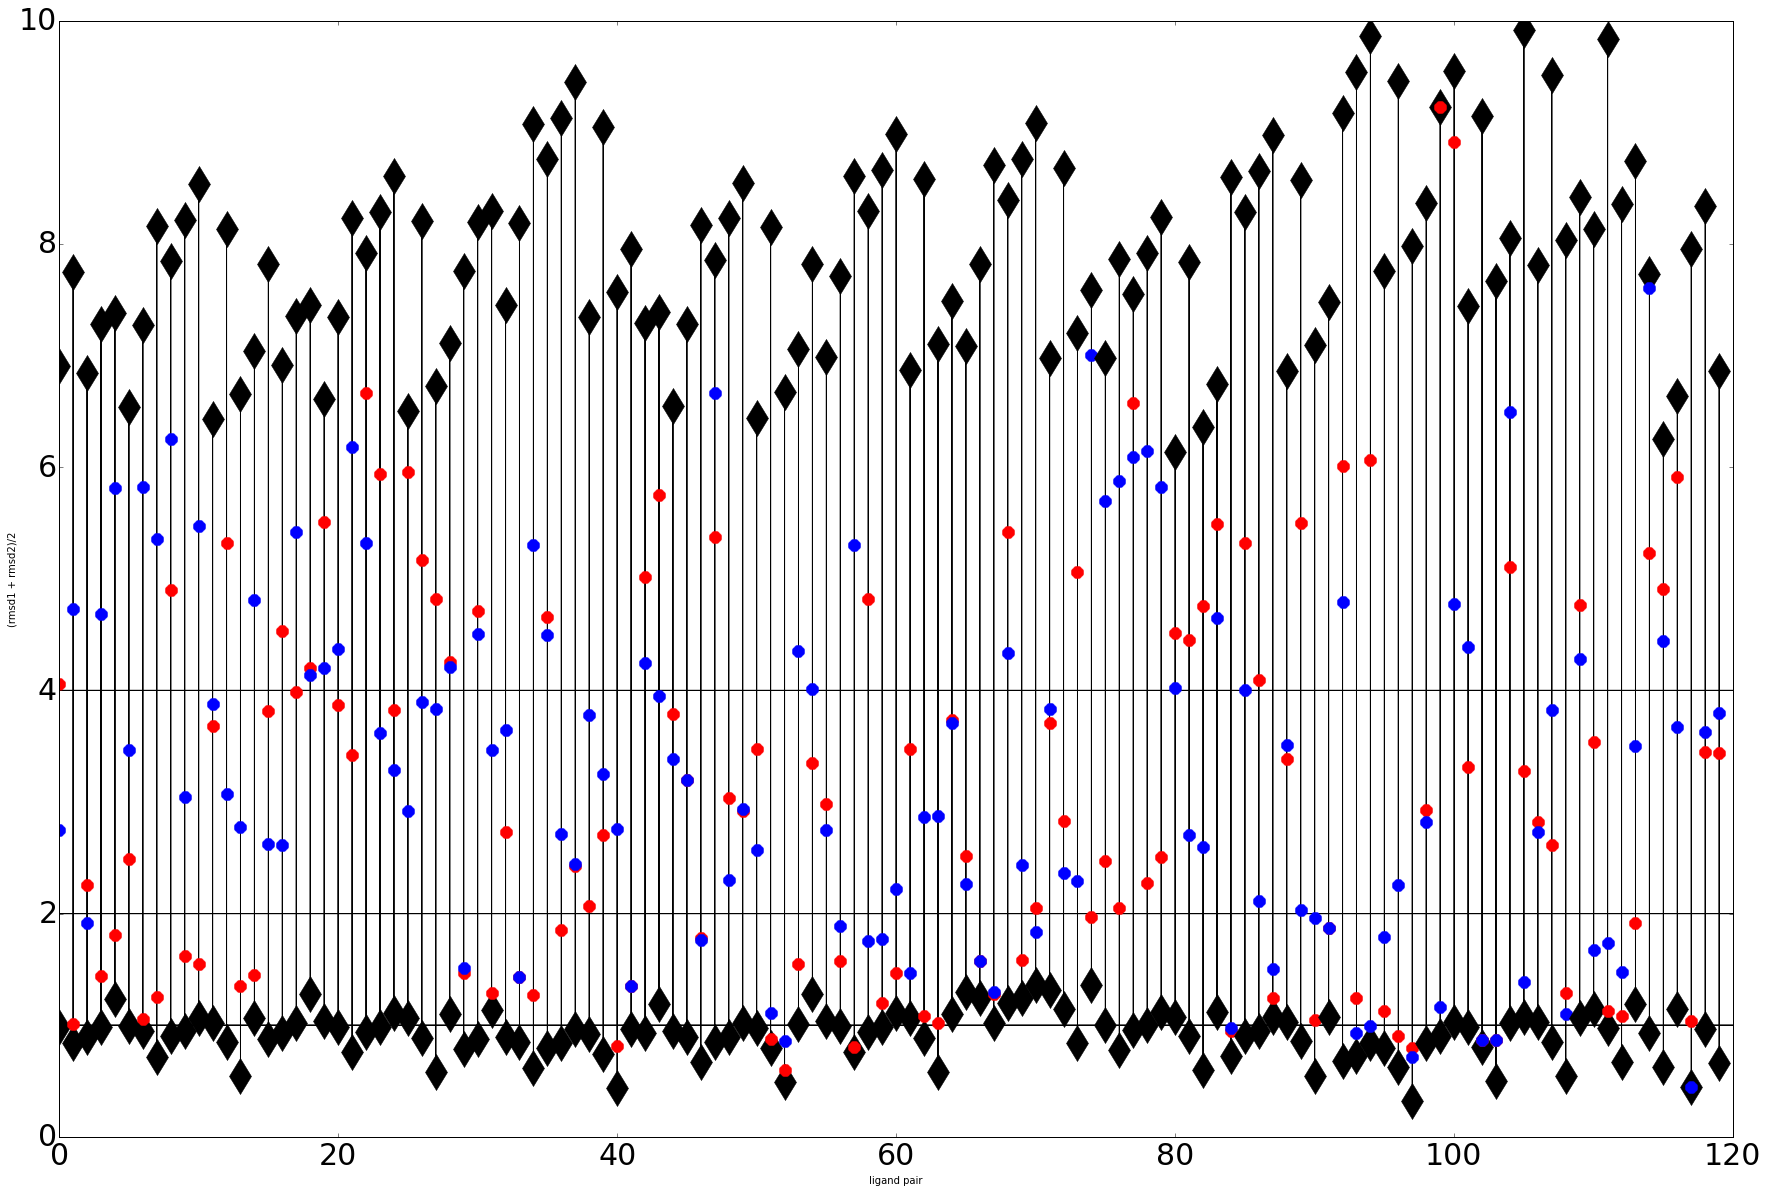

In [19]:
## STEP 6:
## look at the highest-scoring pose of each pair of ligands

get_ipython().magic(u'matplotlib inline')

a = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)

pairs = show_results_for_all_ligand_pairs(scores, lab='label1', scores2=scores2, lab2='label2')

matplotlib.rcParams['figure.figsize'] = a

In [20]:
## STEP 7: find the worst pair
#print pairs
worst_pair = np.argmax([pairs[i][2] for i in pairs])
(l1, l2, worst_rmsd, p1, p2) = pairs[worst_pair]

print 'The highest rmsd value is ' + str(worst_rmsd)
print 'for pair ' + l1 + ', ' + l2

The highest rmsd value is 9.2285
for pair 4EK4, 4FKS


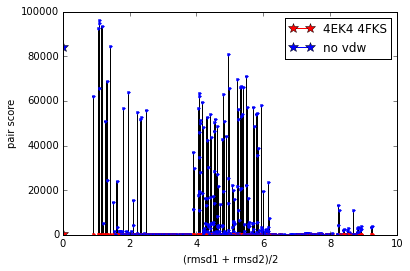

In [21]:
## STEP 8: debug the worst pair

get_ipython().magic(u'matplotlib inline')

plot_all_poses(l1, l2, scores, l1 + ' ' + l2, scores2, 'new bonds')#, scores2, label2)

In [22]:
## use this block to extract interesting pairs from the plot above

'''
scored_pairs[0][pair], # rmsd ave
scored_pairs[1][pair], # gscore sum
scored_pairs[2][pair], # pair score
scored_pairs[3][pair], # l1 pose num
scored_pairs[4][pair]))# l2 pose num
'''

bad_rmsd = lambda r1,r2: (r1+r2)/2.0 >= 2
good_rmsd = lambda r1,r2: (r1+r2)/2.0 <= 1
good_score = lambda score: score >= 50
combo = lambda rmsd, score: score and rmsd

# output: p1, p2, r1, r2, score(p1,p2)
bad_pairs = scores.get_filtered_pose_pairs(l1, l2, bad_rmsd, good_score, combo)
bad_pairs.sort(key=lambda x: x[4])
bad_pairs.reverse()

good_pairs = scores.get_filtered_pose_pairs(l1, l2, good_rmsd, good_score, combo)
good_pairs.sort(key=lambda x: x[4])
good_pairs.reverse()

print l1, l2
print 'Bad pairs:'
for i in range(min(5, len(bad_pairs))):
    print bad_pairs[i]
print 'Good pairs:'
for i in range(min(5, len(good_pairs))):
    print good_pairs[i]

4EK4 4FKS
Bad pairs:
(0, 34, 8.86, 9.597, 580.06808284481633)
(0, 44, 8.86, 9.538, 527.98160085790903)
(2, 34, 8.233, 9.597, 521.94621976780377)
(3, 34, 8.075, 9.597, 520.56899096996665)
(2, 44, 8.233, 9.538, 477.79596686971126)
Good pairs:
(1, 3, 0.858, 0.947, 327.81889400493793)


In [28]:
print glides[l1][best_structure].poses[0].fp.feats['145']
print glides2[l1][best_structure].poses[0].fp.feats['145']

print glides[l2][best_structure].poses[34].fp.feats['145']
print glides2[l2][best_structure].poses[34].fp.feats['145']

[16.0969650225, 5.66847281414e-05, 0.109612077297, -4.69367703902]
[32.015615111, 0.0, 0.109612077297, -4.69367703902]
[12.3373867164, 0.0, 2.15818618498, -5.02211528918]
[58.4971246232, 0.0, 2.15818618498, -5.02211528918]


In [23]:
(bad_score,  bad_interactions)  = scores.get_interactions(l1, l2, bad_pairs[0][0],  bad_pairs[0][1])
(good_score, good_interactions) = scores.get_interactions(l1, l2, good_pairs[0][0], good_pairs[0][1])
(true_score, true_interactions) = scores.get_interactions(l1, l2, -1, -1)

# returns list of tuples: (arg1_strength - arg2_strenth, res, interaction_type)
explore_1 = scores.find_mismatched_interactions(true_interactions, good_interactions)
explore_2 = scores.find_mismatched_interactions(true_interactions, bad_interactions)

explore_1.sort(key=lambda x: abs(x[0]), reverse=True) # sort on absolute value of the mismatch
explore_2.sort(key=lambda x: x[0])

print 'Biggest mismatches between the good pose and the crystal pose'
for i in range(10):
    print explore_1[i]
print '--------'
print 'Biggest negative mismatches between the bad pose and the crystal pose'
for i in range(10):
    print explore_2[i]

Biggest mismatches between the good pose and the crystal pose
(28.407496601940466, '83', 0)
(22.82306893231611, '81', 1)
(8.788899699660346, '85', 3)
(4.687249920757844, '89', 3)
(4.330844571448324, '10', 3)
(-4.119227341157991, '134', 3)
(3.388114465027382, '83', 3)
(-3.254444080929064, '18', 3)
(3.1059891607616024, '82', 3)
(3.0634213209083203, '86', 3)
--------
Biggest negative mismatches between the bad pose and the crystal pose
(-198.59448244294688, '145', 0)
(-97.780678675081, '33', 0)
(-87.0877215209811, '146', 0)
(-51.1626009152221, '80', 3)
(-24.002875726083527, '144', 3)
(-23.60301783010882, '146', 3)
(-22.929473628825885, '145', 3)
(-11.51585595427815, '64', 3)
(-7.200592084966216, '33', 3)
(-5.680785813346411, '18', 3)
